In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timezone
from sklearn.linear_model import LogisticRegression, LinearRegression
from tqdm.notebook import tqdm, trange
import six
import matplotlib.pyplot as plt
import scipy.sparse
import urllib3
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from requests_html import HTMLSession
import swifter
import itertools
from scipy import stats

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# 1. Прочитайте и проанализируйте данные

In [2]:
%%time

tournaments = pd.read_pickle("tournaments.pkl")
results = pd.read_pickle("results.pkl")

Wall time: 17.3 s


In [3]:
TOURNAMENT_ID_KEY = TEAM_ID_KEY = "id"
TOURNAMENT_NAME_KEY = TEAM_ID_KEY = "name"
TOURNAMENT_TEAMS_KEY = "teams"
TEAM_ANSWERS_KEY = "answers"
TEAM_PLAYERS_KEY = "players"

def make_team_dict(team_id, answers, players):
    res = {
        TEAM_ID_KEY: team_id,
        TEAM_ANSWERS_KEY : answers,
        TEAM_PLAYERS_KEY: players,
    }
    return res


def make_tournament_dict(tournament_id, tournament_name, teams):
    res = {
        TOURNAMENT_ID_KEY: tournament_id,
        TOURNAMENT_NAME_KEY: tournament_name,
        TOURNAMENT_TEAMS_KEY: teams,
    }
    return res

In [4]:
POSSIBLE_ANSWERS = {"0", "1"}

def process_answers(answers_string):
    if not isinstance(answers_string, six.string_types) or set(answers_string) - POSSIBLE_ANSWERS:
        return []
    return [int(a) for a in answers_string]
    

def is_valid_team(team_dict):
    players = team_dict[TEAM_PLAYERS_KEY]
    if not players:
        return False
    
    answers = team_dict[TEAM_ANSWERS_KEY]
    if not answers:
        return False
    
    return True


def is_valid_tournament(tournament_dict):
    teams = tournament_dict[TOURNAMENT_TEAMS_KEY]
    if not teams:
        return False
    
    num_answers = None
    for team in teams:
        answers = team[TEAM_ANSWERS_KEY]
        num_answers = num_answers or len(answers)
        if num_answers != len(answers):
            return False
    
    return True

In [5]:
def tournaments_train_test_split(tournaments, results):
    
    TRAIN_YEAR = 2019
    TEST_YEAR = 2020

    TOURNAMENT_DATE_KEY = "dateStart" 
    TOURNAMENT_ID_KEY = TEAM_ID_KEY = PLAYER_ID_KEY = "id"
    RESULT_ANSWERS_KEY = "mask"
    TEAM_MEMBERS_KEY = "teamMembers"
    TEAM_KEY = "team"
    PLAYER_KEY = "player"
    
    train, test = [], []

    for tournament_info in tqdm(tournaments.values()):
    
        tournament_year = datetime.fromisoformat(tournament_info[TOURNAMENT_DATE_KEY]).year
        if tournament_year not in (TRAIN_YEAR, TEST_YEAR):
            continue
    
        tournament_id = tournament_info[TOURNAMENT_ID_KEY]
        tournament_name = tournament_info[TOURNAMENT_NAME_KEY]
        
        tournament_result = results[tournament_id]
        if not tournament_result:
            continue
    
        teams = []
        for team in tournament_result:
            team_id = team[TEAM_KEY][TEAM_ID_KEY]
        
            answers = process_answers(team.get(RESULT_ANSWERS_KEY))
        
            players = []
            for member in team[TEAM_MEMBERS_KEY]:
                player_id = member[PLAYER_KEY][PLAYER_ID_KEY]
                players.append(player_id)
        
            team_dict = make_team_dict(team_id, answers, players)
            if not is_valid_team(team_dict):
                continue
            teams.append(team_dict)
        
        tournament_dict = make_tournament_dict(tournament_id, tournament_name, teams)
        if not is_valid_tournament(tournament_dict):
            continue
    
        if tournament_year == TRAIN_YEAR:
            train.append(tournament_dict)
        else:
            test.append(tournament_dict)
            
    return train, test

In [6]:
train, test = tournaments_train_test_split(tournaments, results)

del tournaments, results

In [7]:
print(f"Количество турниров для обучения модели: {len(train)}")
print(f"Количество турниров для тестирования модели: {len(test)}")

Количество турниров для обучения модели: 604
Количество турниров для тестирования модели: 156


In [8]:
unique_players = set()

for tournament in tqdm(train): 
    teams = tournament[TOURNAMENT_TEAMS_KEY]
    for team in teams:
        players = team[TEAM_PLAYERS_KEY]
        unique_players.update(players)
        
player_idx_map = {player: idx for idx, player in enumerate(unique_players)}

In [9]:
num_players = len(player_idx_map)

player_num_answers = np.zeros(num_players)
player_num_correct_answers = np.zeros(num_players)
player_num_tournaments = np.zeros(num_players)
player_teams = [set() for _ in range(num_players)]

num_questions = 0
unique_teams = set()
for tournament in tqdm(train): 
    teams = tournament[TOURNAMENT_TEAMS_KEY]
    
    first_team = True
    for team in teams:
        team_id = team[TEAM_ID_KEY]
        unique_teams.add(team_id)
        
        answers = team[TEAM_ANSWERS_KEY]
        num_answers = len(answers)
        num_correct_answers = sum(answers)
        if first_team:
            num_questions += num_answers
        
        players = team[TEAM_PLAYERS_KEY]
        for player in players:
            player_idx = player_idx_map[player]
            player_num_answers[player_idx] += num_answers
            player_num_correct_answers[player_idx] += num_correct_answers
            player_num_tournaments[player_idx] += 1
            player_teams[player_idx].add(team_id)
        
        first_team = False
        
player_num_teams = np.array([len(pt) for pt in player_teams])
player_correct_ratio = player_num_correct_answers / player_num_answers

In [10]:
print(f"Уникальных игроков в турнирах для обучения: {num_players}")
print(f"Команд в турнирах для обучения: {len(unique_teams)}")
print(f"Было задано вопросов в турнирах для обучения: {num_questions}")
print(f"В среднем вопросов на турнир: {int(num_questions / len(train))}")

Уникальных игроков в турнирах для обучения: 55151
Команд в турнирах для обучения: 10996
Было задано вопросов в турнирах для обучения: 28264
В среднем вопросов на турнир: 46


In [11]:
def describe(array, title=""):
    res = pd.Series(array).describe().to_frame().T
    res.index = [title]
    display(res)
    
    plt.hist(player_num_tournaments)
    plt.title(title)
    plt.show()

,count,mean,std,min,25%,50%,75%,max
В скольких турнирах участвовали игроки,55151.0,6.220341,11.658492,1.0,1.0,2.0,5.0,184.0


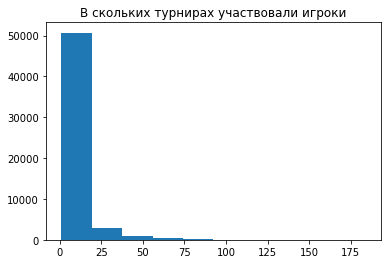

,count,mean,std,min,25%,50%,75%,max
На сколько вопросов ответили игроки,55151.0,249.307955,466.594843,24.0,36.0,72.0,216.0,7075.0


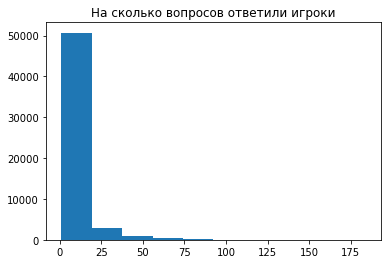

,count,mean,std,min,25%,50%,75%,max
На сколько вопросов ответили игроки правильно,55151.0,107.220105,244.196935,0.0,11.0,25.0,80.0,4061.0


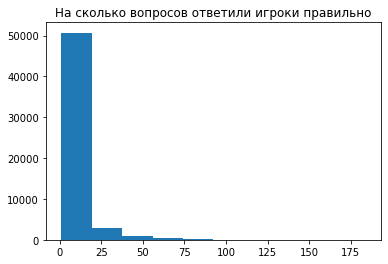

,count,mean,std,min,25%,50%,75%,max
Доля правильных ответов у игроков,55151.0,0.337397,0.163131,0.0,0.214559,0.333333,0.45641,0.916667


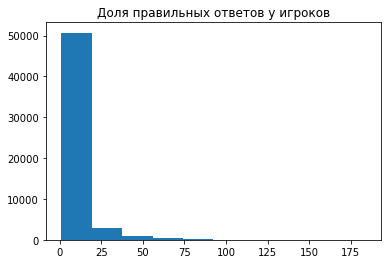

,count,mean,std,min,25%,50%,75%,max
В скольких командах находились игроки,55151.0,1.593552,1.980362,1.0,1.0,1.0,1.0,54.0


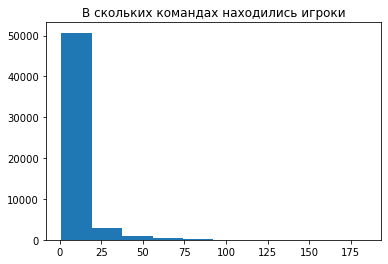

In [12]:
describe(player_num_tournaments, "В скольких турнирах участвовали игроки")
describe(player_num_answers, "На сколько вопросов ответили игроки")
describe(player_num_correct_answers, "На сколько вопросов ответили игроки правильно")
describe(player_correct_ratio, "Доля правильных ответов у игроков")
describe(player_num_teams, "В скольких командах находились игроки")

# 2. Baseline-модель оценки рейтинга игроков

### $x = concatenate(one\_hot(question), one\_hot(player))$
### $y = I(answer~was~correct)$

#### Обучим лог. регрессию. Ее коэффициенты, отвечающие вопросам будут отвечать за их сложность, игрокам - их способностям. Отранжируем игроков и получим подобие рейтинга.

In [13]:
CORRECT_LABEL = 1
INCORRECT_LABEL = 0

question_player_correct = [[] for _ in range(num_questions)]
question_player_incorrect = [[] for _ in range(num_questions)]
question_player_correct_team = [[] for _ in range(num_questions)]
question_player_incorrect_team = [[] for _ in range(num_questions)]

question_tournament = [None] * num_questions

max_question_id = -1
for tournament in tqdm(train): 
    tournament_name = tournament[TOURNAMENT_NAME_KEY]
    teams = tournament[TOURNAMENT_TEAMS_KEY]
    for team in teams:
        team_id = team[TEAM_ID_KEY]
        answers = team[TEAM_ANSWERS_KEY]
        players = team[TEAM_PLAYERS_KEY]
        for question_id, answer in enumerate(answers, 1):
            question_id += max_question_id
            
            question_tournament[question_id] = tournament_name
            
            for player in players:
                player_idx = player_idx_map[player]
                if answer == CORRECT_LABEL:
                    question_player_correct[question_id].append(player_idx)
                    question_player_correct_team[question_id].append(team_id)
                else:
                    question_player_incorrect[question_id].append(player_idx)
                    question_player_incorrect_team[question_id].append(team_id)
    
    max_question_id = question_id

In [14]:
def construct_sparse_matrix(question_player, dtype=None):
    row = []
    col = []
    data = []
    
    max_row_idx = -1
    max_player_idx = -1
    for question_idx, player_idx_collection in enumerate(question_player):
        for row_idx, player_idx in enumerate(player_idx_collection, 1):
            if player_idx > max_player_idx:
                max_player_idx = player_idx
            row_idx += max_row_idx
            
            row.append(row_idx)
            col.append(question_idx)
            data.append(1)
            
            row.append(row_idx)
            col.append(len(question_player) + player_idx)
            data.append(1)
            
        max_row_idx = row_idx
    num_rows = max_row_idx + 1
    num_cols = max_player_idx + 1 + len(question_player)
    coo = scipy.sparse.coo_matrix((data, (row, col)), shape=(num_rows, num_cols), dtype=dtype)
    return coo


def make_Xy(question_player_correct, question_player_incorrect, dtype=None):
    correct_coo = construct_sparse_matrix(question_player_correct, dtype=dtype)
    incorrect_coo = construct_sparse_matrix(question_player_incorrect, dtype=dtype)
    
    X = scipy.sparse.vstack([correct_coo, incorrect_coo]).tocsr()
    y = np.array(
        [CORRECT_LABEL] * correct_coo.shape[0] + [INCORRECT_LABEL] * incorrect_coo.shape[0]
    )
    
    return X, y


def _extend_question_team(t, question_player_team):
    for team_collection in question_player_team:
        t.extend(team_collection)
        

def make_t(question_player_correct_team, question_player_incorrect_team):
    t = []
    _extend_question_team(t, question_player_correct_team)
    _extend_question_team(t, question_player_incorrect_team)
    t = np.array(t)
    return t

In [15]:
%%time

X, y = make_Xy(question_player_correct, question_player_incorrect, dtype=np.uint8)

Wall time: 20.6 s


In [16]:
%%time

lr = LogisticRegression(solver="sag", n_jobs=-1)
lr.fit(X, y)

Wall time: 5min 51s


LogisticRegression(n_jobs=-1, solver='sag')

In [17]:
idx_player_map = {idx: player for player, idx in player_idx_map.items()}

player_baseline_ratings_ = {}
for idx, rating in enumerate(lr.coef_.flatten()[len(question_player_correct):]):
    player_baseline_ratings_[idx_player_map[idx]] = rating

player_baseline_ratings_ = dict(sorted(player_baseline_ratings_.items(), key=lambda x: -x[1]))

assert len(player_baseline_ratings_) == len(idx_player_map)

In [18]:
def session_with_retries(session, retries=5, backoff_factor=0.3, status_forcelist=(500, 502, 504)):
    retry = Retry(total=retries, read=retries, connect=retries, backoff_factor=backoff_factor,
                  status_forcelist=status_forcelist)
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    return session


def get_player_actual_rating(player_id, verify=False, **get_kws):
    URL = f"https://rating.chgk.info/api/players/{player_id}/rating/last"
    RATING_KEY = "rating_position"
    
    with session_with_retries(HTMLSession()) as session:
        response = session.get(URL, verify=verify, **get_kws)
    response_json = response.json()
    if response_json:
        actual_rating = response_json[RATING_KEY]
        actual_rating = int(actual_rating)
        return actual_rating
    return 0

In [19]:
player_baseline_ratings = pd.Series(player_baseline_ratings_).reset_index().head(1000)
player_baseline_ratings.columns = ["player_id", "baseline_score"]
player_baseline_ratings["actual_rating"] = player_baseline_ratings["player_id"].swifter.apply(get_player_actual_rating)
player_baseline_ratings = player_baseline_ratings.loc[player_baseline_ratings["actual_rating"] != 0].copy()
player_baseline_ratings["baseline_rating"] = range(1, len(player_baseline_ratings) + 1)

player_baseline_ratings.head(40)

,player_id,baseline_score,actual_rating,baseline_rating
0,27403,4.069346,5,1
1,4270,3.932631,6,2
2,28751,3.885276,3,3
3,27822,3.853123,2,4
4,30270,3.758595,4,5
5,30152,3.752955,1,6
6,18036,3.619290,8,7
7,20691,3.614514,38,8
8,87637,3.542940,158,9
9,22799,3.539623,10,10


In [20]:
def kendall(x, y):
    corr, _ = stats.kendalltau(x, y)
    return corr

def spearman(x, y):
    corr, _ = stats.spearmanr(x, y)
    return corr

In [21]:
kendall_corr_baseline_actual_rating = kendall(
    player_baseline_ratings["baseline_rating"], player_baseline_ratings["actual_rating"]
)

spearman_corr_baseline_actual_rating = spearman(
    player_baseline_ratings["baseline_rating"], player_baseline_ratings["actual_rating"]
)

print(f"Корреляция Кенделла между бейзлановыми рейтингами игроков и реальными: {kendall_corr_baseline_actual_rating}")
print(f"Корреляция Cпирмена между бейзлановыми рейтингами игроков и реальными: {spearman_corr_baseline_actual_rating}")

Корреляция Кенделла между бейзлановыми рейтингами игроков и реальными: 0.3357155166960077
Корреляция Cпирмена между бейзлановыми рейтингами игроков и реальными: 0.47966945141505996


# 3. Модель предсказания результатов нового турнира с неизвестными вопросами

### Попробуем несколько стратегий ранжирования команд:
#### 1) по рейтингу лучшего игрока
#### 2) по среднему рейтингу всех игроков
#### 3) по среднему рейтингу двух лучших игроков
#### 4) с помощью обученной модели, для каждого нового турнира просэмплируем вопросы из трейна и попробуем предсказать, ответят ли на них команды (посчитаем вероятность того, что хотя бы один член команды ответит), найдем кол-во вопросов, на которые ответила команда

In [22]:
NUM_QUESTIONS = int(num_questions / len(train))


def fillna_and_sort_team_player_scores(team_player_scores):
    team_player_scores_flatten = [s for s in itertools.chain(*team_player_scores) if s is not None]
    player_avg_score = np.mean(team_player_scores_flatten)
    
    for i, _ in enumerate(team_player_scores):
        team_player_scores[i] = sorted([s if s is not None else player_avg_score for s in team_player_scores[i]], reverse=True)


def estimated_team_ranking(teams, player_ratings, aggregated_top=1):
    team_player_scores = [None] * len(teams) 
    for idx, team in enumerate(teams):
        players = team[TEAM_PLAYERS_KEY]
        player_scores = [player_ratings.get(player) for player in players]
        team_player_scores[idx] = player_scores
    
    fillna_and_sort_team_player_scores(team_player_scores)
    
    team_estimated_scores = np.array([np.mean(tps[:aggregated_top]) for tps in team_player_scores])
    team_estimated_ranking = np.argsort(-team_estimated_scores) + 1
    
    return team_estimated_ranking


def actual_team_ranking(teams):
    team_actual_scores = [None] * len(teams) 
    for idx, team in enumerate(teams):
        answers = team[TEAM_ANSWERS_KEY]
        team_actual_scores[idx] = sum(answers)
    
    team_actual_scores = np.array(team_actual_scores)
    team_actual_ranking = np.argsort(-team_actual_scores) + 1
    
    return team_actual_ranking


def construct_one_hot(idx, size):
    row = [0]
    col = [idx]
    data = [1]
    one_hot = scipy.sparse.coo_matrix((data, (row, col)), shape=(1, size))
    return one_hot


def construct_question_player_row(question_idx, player_idx, size):
    qsize, psize = size
    question_one_hot = construct_one_hot(question_idx, qsize)
    player_one_hot = construct_one_hot(player_idx, psize)
    res = scipy.sparse.hstack([question_one_hot, player_one_hot])
    return res


def model_predict_team_ranking(model, teams, player_idx_map, question_player, num_questions, correct_answer_prob_threshold=0.5):
    qsize = len(question_player)
    psize = len(player_idx_map)
    
    question_idxs = np.random.choice(range(len(question_player)), size=num_questions)
    
    team_predicted_scores = [0] * len(teams)
    for team_idx, team in enumerate(teams):
        players = team[TEAM_PLAYERS_KEY]
        player_idxs = [player_idx_map[player] for player in players if player in player_idx_map]
        
        for question_idx in question_idxs:
            rows = [
                construct_question_player_row(question_idx, player_idx, size=(qsize, psize))
                for player_idx in player_idxs
            ]
            if not rows:
                continue
            rows = scipy.sparse.vstack(rows)
            probas = model.predict_proba(rows)[:, 0]
            wrong_answer_proba = np.prod(probas)
            correct_answer_proba = 1 - wrong_answer_proba
            if correct_answer_proba >= correct_answer_prob_threshold:
                team_predicted_scores[team_idx] += 1
                
    team_predicted_scores = np.array(team_predicted_scores)
    team_predicted_ranking = np.argsort(-team_predicted_scores) + 1
    
    return team_predicted_ranking

In [23]:
top1_kendall_corrs, top1_spearman_corrs = [], []
top2_kendall_corrs, top2_spearman_corrs = [], []
topn_kendall_corrs, topn_spearman_corrs = [], []
lr_model_kendall_corrs, lr_model_spearman_corrs = [], []

for tournament in tqdm(test): 
    teams = tournament[TOURNAMENT_TEAMS_KEY]
    
    actual_ranking = actual_team_ranking(teams)
    
    top1_ranking = estimated_team_ranking(teams, player_baseline_ratings_, 1)
    top1_kendall_corrs.append(kendall(actual_ranking, top1_ranking))
    top1_spearman_corrs.append(spearman(actual_ranking, top1_ranking))
    
    top2_ranking = estimated_team_ranking(teams, player_baseline_ratings_, 2)
    top2_kendall_corrs.append(kendall(actual_ranking, top2_ranking))
    top2_spearman_corrs.append(spearman(actual_ranking, top2_ranking))    
    
    topn_ranking = estimated_team_ranking(teams, player_baseline_ratings_, 100)
    topn_kendall_corrs.append(kendall(actual_ranking, topn_ranking))
    topn_spearman_corrs.append(spearman(actual_ranking, topn_ranking))

    lr_model_ranking = model_predict_team_ranking(lr, teams, player_idx_map, question_player_correct, NUM_QUESTIONS)
    lr_model_kendall_corrs.append(kendall(actual_ranking, lr_model_ranking))
    lr_model_spearman_corrs.append(spearman(actual_ranking, lr_model_ranking))

    
print(f"1) Корреляция Кенделла на тестовом множестве: {np.mean(top1_kendall_corrs)}")
print(f"1) Корреляция Cпирмена на тестовом множестве: {np.mean(top1_spearman_corrs)}")
print()
print(f"2) Корреляция Кенделла на тестовом множестве: {np.mean(top2_kendall_corrs)}")
print(f"2) Корреляция Cпирмена на тестовом множестве: {np.mean(top2_spearman_corrs)}")
print()
print(f"3) Корреляция Кенделла на тестовом множестве: {np.mean(topn_kendall_corrs)}")
print(f"3) Корреляция Cпирмена на тестовом множестве: {np.mean(topn_spearman_corrs)}")
print()
print(f"4) Корреляция Кенделла на тестовом множестве: {np.mean(lr_model_kendall_corrs)}")
print(f"4) Корреляция Cпирмена на тестовом множестве: {np.mean(lr_model_spearman_corrs)}")


1) Корреляция Кенделла на тестовом множестве: 0.5427771027044038
1) Корреляция Cпирмена на тестовом множестве: 0.7152968166743182

2) Корреляция Кенделла на тестовом множестве: 0.5665334606346141
2) Корреляция Cпирмена на тестовом множестве: 0.7398012765020647

3) Корреляция Кенделла на тестовом множестве: 0.5538631083626137
3) Корреляция Cпирмена на тестовом множестве: 0.7206175006249541

4) Корреляция Кенделла на тестовом множестве: 0.6068042156544243
4) Корреляция Cпирмена на тестовом множестве: 0.7760099244452489


# 4.EM - алгоритм

### В качестве вектора скрытых переменных рассмотрим величину

$$z = P(player~gave~correct~answer|team~gave~correct~answer)$$

$z = \frac{P(team~gave~correct~answer|player~gave~correct~answer) P(player~gave~correct~answer)}{P(team~gave~correct~answer)} = \frac{P(player~gave~correct~answer)}{P(team~gave~correct~answer)}$

In [28]:
class ProbaLinearRegression(LinearRegression):
    def predict_proba(self, X):
        positive_preds = self.predict(X).clip(0, 1).reshape(-1, 1)
        negative_preds = (1 - positive_preds).reshape(-1, 1)
        res = np.hstack((negative_preds, positive_preds))
        return res

In [29]:
%%time

plr = ProbaLinearRegression()
plr.fit(X, y)

Wall time: 2min 45s


ProbaLinearRegression()

In [30]:
def model_metrics(model):
    model_kendall_corrs, model_spearman_corrs = [], []

    for tournament in test: 
        teams = tournament[TOURNAMENT_TEAMS_KEY]
    
        actual_ranking = actual_team_ranking(teams)
    
        model_ranking = model_predict_team_ranking(model, teams, player_idx_map, question_player_correct, NUM_QUESTIONS)
        model_kendall_corrs.append(kendall(actual_ranking, model_ranking))
        model_spearman_corrs.append(spearman(actual_ranking, model_ranking))
    
    print(f"Корреляция Кенделла на тестовом множестве: {np.mean(model_kendall_corrs)}")
    print(f"Корреляция Cпирмена на тестовом множестве: {np.mean(model_spearman_corrs)}")
    print()

In [31]:
model_metrics(plr)

Корреляция Кенделла на тестовом множестве: 0.6077050395870799
Корреляция Cпирмена на тестовом множестве: 0.7786226463667782



In [32]:
question_team = make_t(question_player_correct_team, question_player_incorrect_team)
question = []

for i in range(num_questions):
    tmp = [i] * len(question_player_correct[i])
    question.extend(tmp)
    
for i in range(num_questions):
    tmp = [i] * len(question_player_incorrect[i])
    question.extend(tmp)
    
question = np.array(question)

In [33]:
ITERATIONS = 1

for i in range(ITERATIONS):
    print(f"Итерация: {i}")
    
    # E-шаг
    preds = plr.predict_proba(X)
    player_incorrect_proba, player_correct_proba = preds[:, 0], preds[:, 1]
            
    player_stats = pd.DataFrame({
        "team": question_team, 
        "question": question, 
        "player_incorrect_proba": player_incorrect_proba,
        "player_correct_proba": player_correct_proba, 
    })
    team_stats = (
        player_stats
        .groupby(["team", "question"])["player_incorrect_proba"]
        .prod()
        .reset_index()
        .rename(columns={"player_incorrect_proba": "team_incorrect_proba"})
    )
    team_stats["team_correct_proba"] = (1 - team_stats["team_incorrect_proba"])
    all_stats = player_stats.merge(team_stats, on=["team", "question"])
    z = (all_stats["player_correct_proba"] / all_stats["team_correct_proba"]).fillna(1).values.clip(0, 1)
    z[y == 0] = 0
    
    # M - шаг
    plr.fit(X, z)
    
    # Вывод метрик
    model_metrics(plr)

Итерация: 0
Корреляция Кенделла на тестовом множестве: 0.6255935095912233
Корреляция Cпирмена на тестовом множестве: 0.7935776100431585



In [34]:
player_em_ratings_ = {}
for idx, rating in enumerate(plr.coef_.flatten()[len(question_player_correct):]):
    player_em_ratings_[idx_player_map[idx]] = rating

player_em_ratings_ = dict(sorted(player_em_ratings_.items(), key=lambda x: -x[1]))

assert len(player_em_ratings_) == len(idx_player_map)

In [35]:
player_em_ratings = pd.Series(player_em_ratings_).reset_index().head(1000)
player_em_ratings.columns = ["player_id", "em_score"]
player_em_ratings["actual_rating"] = player_em_ratings["player_id"].swifter.apply(get_player_actual_rating)
player_em_ratings = player_em_ratings.loc[player_em_ratings["actual_rating"] != 0].copy()
player_em_ratings["em_rating"] = range(1, len(player_em_ratings) + 1)

player_em_ratings.head(40)

,player_id,em_score,actual_rating,em_rating
0,27403,0.624334,5,1
1,38175,0.620120,9944,2
2,4270,0.603214,6,3
3,28751,0.596631,3,4
4,27822,0.594247,2,5
7,30152,0.573559,1,6
8,30270,0.569780,4,7
9,26089,0.562250,65,8
10,18036,0.560732,8,9
11,20691,0.556081,38,10


In [36]:
kendall_corr_em_actual_rating = kendall(
    player_em_ratings["em_rating"], player_em_ratings["actual_rating"]
)

spearman_corr_em_actual_rating = spearman(
    player_em_ratings["em_rating"], player_em_ratings["actual_rating"]
)

print(f"Корреляция Кенделла между em рейтингами игроков и реальными: {kendall_corr_em_actual_rating}")
print(f"Корреляция Cпирмена между em рейтингами игроков и реальными: {spearman_corr_em_actual_rating}")

Корреляция Кенделла между em рейтингами игроков и реальными: 0.20960942633339164
Корреляция Cпирмена между em рейтингами игроков и реальными: 0.30442184939519784


# 5. Рейтинг вопросов

In [37]:
question_em_ratings = {}
for idx, rating in enumerate(plr.coef_.flatten()[:len(question_tournament)]):
    question_em_ratings[question_tournament[idx]] = rating

question_em_ratings = dict(sorted(question_em_ratings.items(), key=lambda x: -x[1]))

In [38]:
question_em_ratings = pd.Series(question_em_ratings).reset_index().head(1000)
question_em_ratings.columns = ["tournament_name", "em_score"]
question_em_ratings["em_rating"] = range(1, len(question_em_ratings) + 1)

question_em_ratings.head(40)

,tournament_name,em_score,em_rating
0,"Весенний Братский Кубок ""От Винта""",0.696014,1
1,Первое зеркало ЮЧЕ,0.688952,2
2,Альпийский Эдельвейс,0.680178,3
3,One ring - async,0.654178,4
4,Кубок кабачков,0.648891,5
5,Кубок Югры,0.640410,6
6,Шестой киевский марафон. Асинхрон,0.630670,7
7,Чёрная Быль,0.628290,8
8,Школьная лига. II тур.,0.626693,9
9,Кубок Закарпатья,0.611037,10
